In [15]:
# RQ2: Consistency Between PR Descriptions and Actual Code Changes
# Goal:
#   Compare AI-generated PR descriptions (title + body)
#   against real code change signals extracted from Git patches.
#
#   We classify PRs into:
#       - aligned
#       - missing-tests
#       - fix-doc-mismatch
#       - refactor-mismatch
#
#   Based on keyword overlap vs. file types & patch diff signals.

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the Dataset
all_pull_request = load_dataset("hao-li/AIDev", "all_pull_request")["train"]
pr_commit_details = load_dataset("hao-li/AIDev", "pr_commit_details")["train"]
pr_commits = load_dataset("hao-li/AIDev", "pr_commits")["train"]

# Convert HuggingFace Dataset → Pandas DataFrame
ai_df = pd.DataFrame(all_pull_request)          # title + body + metadata
commit_details_df = pd.DataFrame(pr_commit_details)  # file-level diffs

# Clean PR Title / Body

# Replace NULLs and convert to string
ai_df["title"] = ai_df["title"].fillna("").astype(str)
ai_df["body"] = ai_df["body"].fillna("").astype(str)

# Remove trailing spaces in agent column
ai_df["agent"] = ai_df["agent"].str.strip()


In [2]:
# Extract Keywords from Title / Body
def extract_keywords(text):
    """
    Identify intent keywords based on textual patterns.
    These represent the *claimed* actions in the PR description.
    """
    
    text = text.lower()
    keywords = []

    if "fix" in text or "bug" in text or "error" in text:
        keywords.append("fix")

    if "test" in text or "coverage" in text:
        keywords.append("test")

    if "refactor" in text or "clean" in text or "optimiz" in text:
        keywords.append("refactor")

    if "doc" in text or "readme" in text:
        keywords.append("doc")

    return keywords

ai_df["title_keywords"] = ai_df["title"].apply(extract_keywords)
ai_df["body_keywords"] = ai_df["body"].apply(extract_keywords)

## Combine title + body keywords (remove duplicates)
ai_df["desc_keywords"] = ai_df.apply(
    lambda row: list(set(row["title_keywords"] + row["body_keywords"])),
    axis=1
)

#check first 5 rows
ai_df[["title", "body", "desc_keywords"]].head()

0            []
1         [fix]
2            []
3            []
4            []
          ...  
932786       []
932787       []
932788    [fix]
932789    [doc]
932790       []
Name: title_keywords, Length: 932791, dtype: object
0                              [fix]
1                   [fix, test, doc]
2                             [test]
3                             [test]
4         [fix, test, refactor, doc]
                     ...            
932786                            []
932787                   [fix, test]
932788                        [test]
932789                   [test, doc]
932790                   [fix, test]
Name: body_keywords, Length: 932791, dtype: object


,title,body,desc_keywords
0,`metta code` --> `metta clip` and additional p...,Remove unused `root_key` variable to fix ruff ...,[fix]
1,feat: Comprehensive ruff error resolution with...,## 🎯 Mission Accomplished: 100% Ruff Error Res...,"[doc, test, fix]"
2,Add Evals frontend implementation plan and HTM...,\nCreate comprehensive implementation plan for...,[test]
3,Add 4 new BfDs components for Evals interface ...,\nPhase 1 component creation for the Evals fro...,[test]
4,🚀 Complete Frontend-Backend API Integration wi...,## 🎯 Summary\n\nThis PR completes the **fronte...,"[doc, test, fix, refactor]"


In [3]:
# Classify File Types (test / doc / source)
def classify_file(filename):
    """
    Map filename to high-level categories:
       - test
       - doc
       - source (default)
    """
    if filename is None:
        return "unknown"

    fn = str(filename).lower()

    if "test" in fn:
        return "test"
    elif fn.endswith(".md") or fn.endswith(".rst") or "doc" in fn or "readme" in fn:
        return "doc"
    else:
        return "source"

commit_details_df["file_type"] = commit_details_df["filename"].apply(classify_file)


In [4]:
# Extract Patch Keywords (fix / add / remove / refactor)
def extract_patch_keywords(patch):
    """
    Scan raw Git patch text for operational signals.
    These represent what actually happened in the code diff.
    """
    if patch is None:
        return []

    text = str(patch).lower()
    keys = []

    if re.search(r"\bfix(ed|es)?\b", text):
        keys.append("fix")

    if re.search(r"\badd(ed|s|ing)?\b", text):
        keys.append("add")

    if re.search(r"\bremove(d|s)?\b", text):
        keys.append("remove")

    if re.search(r"\brefactor(ed)?\b|\bclean\b|\bsimplif", text):
        keys.append("refactor")

    return keys

commit_details_df["patch_keywords"] = commit_details_df["patch"].apply(extract_patch_keywords)

In [10]:
# Summarize Diff Signals at the PR Level

"""
| Column             | Meaning                                      |
| ------------------ | -------------------------------------------- |
| **pr_id**          | PR identifier (joins with ai_df)             |
| **file_type**      | Whether the PR touched test/doc/source files |
| **additions**      | Total lines added                            |
| **deletions**      | Total lines removed                          |
| **changes**        | additions + deletions                        |
| **patch_keywords** | Intent clues found inside the actual patch   |

"""

file_signals = commit_details_df.groupby("pr_id").agg({

    # Unique set of file types touched in the PR
    "file_type": lambda x: list(set(x)),

    # Total additions / deletions / changes
    "additions": "sum",
    "deletions": "sum",
    "changes": "sum",

    # Combine patch-level keywords (flatten + dedupe)
    "patch_keywords": lambda x: list(set(k for lst in x for k in lst))

}).reset_index()

# Preview the first few rows
file_signals.head()


,pr_id,file_type,additions,deletions,changes,patch_keywords
0,2756921963,"[source, test]",848.0,344.0,1192.0,[remove]
1,2757103560,"[source, test]",517.0,262.0,779.0,[remove]
2,2757124156,[doc],1.0,1.0,2.0,[]
3,2757125491,[doc],1.0,1.0,2.0,[]
4,2757179026,"[source, test]",1633.0,169.0,1802.0,"[remove, add, fix, refactor]"


In [6]:
# Merge PR description with diff signals
merged = ai_df.merge(
    file_signals,
    left_on="id",
    right_on="pr_id",
    how="inner"
)

In [8]:
# Define Consistency Rules (RQ2)
def rule_fix_mismatch(row):
    """
    If description claims 'fix' but no source files changed → mismatch.
    """
    return "fix" in row["desc_keywords"] and "source" not in row["file_type"]

def rule_test_mismatch(row):
    """
    If description claims 'test' but no test files modified → mismatch.
    """
    return "test" in row["desc_keywords"] and "test" not in row["file_type"]

def rule_refactor_mismatch(row):
    """
    If description claims 'refactor' but patch behaves like feature-add
    (additions > deletions) → mismatch.
    """
    return "refactor" in row["desc_keywords"] and (row["additions"] > row["deletions"])

def detect_alignment(row):
    """
    Apply rules in order of importance:
        fix mismatch > missing tests > refactor mismatch > aligned
    """
    if rule_fix_mismatch(row):
        return "fix-doc-mismatch"
    if rule_test_mismatch(row):
        return "missing-tests"
    if rule_refactor_mismatch(row):
        return "refactor-mismatch"
    return "aligned"

merged["alignment_result"] = merged.apply(detect_alignment, axis=1)
counts = merged["alignment_result"].value_counts()
print(counts)

alignment_result
aligned              16812
missing-tests        12676
fix-doc-mismatch      2666
refactor-mismatch     1426
Name: count, dtype: int64


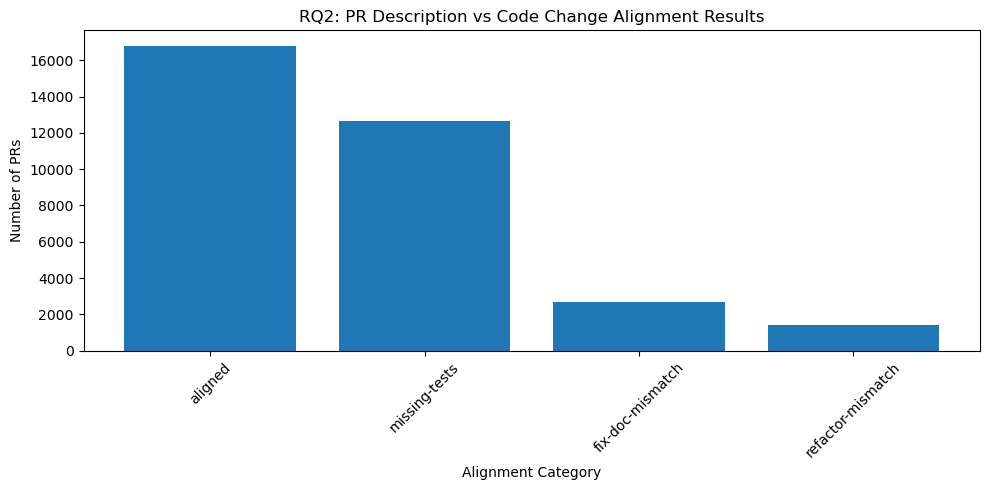

In [11]:
#How many PRs fall into each alignment category?”
import matplotlib.pyplot as plt

# Count alignment categories
counts = merged["alignment_result"].value_counts()

# Bar chart
plt.figure(figsize=(10, 5))
plt.bar(counts.index, counts.values)
plt.title("RQ2: PR Description vs Code Change Alignment Results")
plt.xlabel("Alignment Category")
plt.ylabel("Number of PRs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


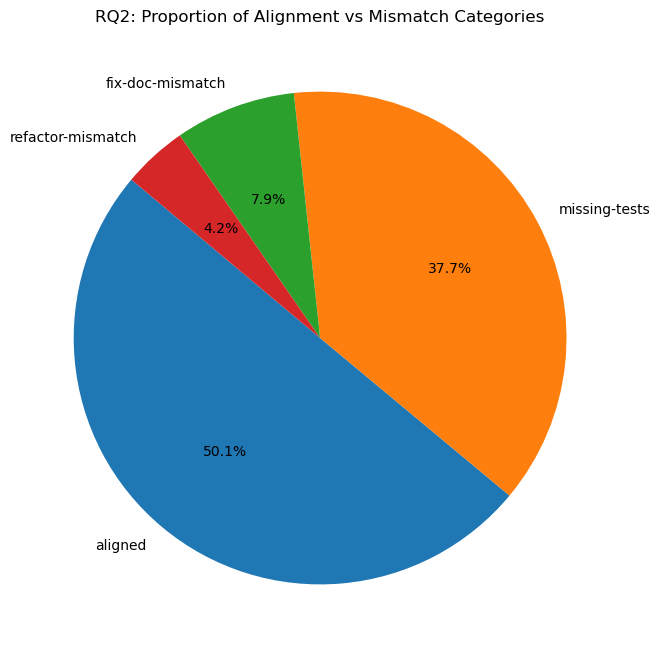

In [12]:
#What percentage of PRs fall into each category?”
plt.figure(figsize=(8, 8))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("RQ2: Proportion of Alignment vs Mismatch Categories")
plt.show()


<Figure size 1200x600 with 0 Axes>

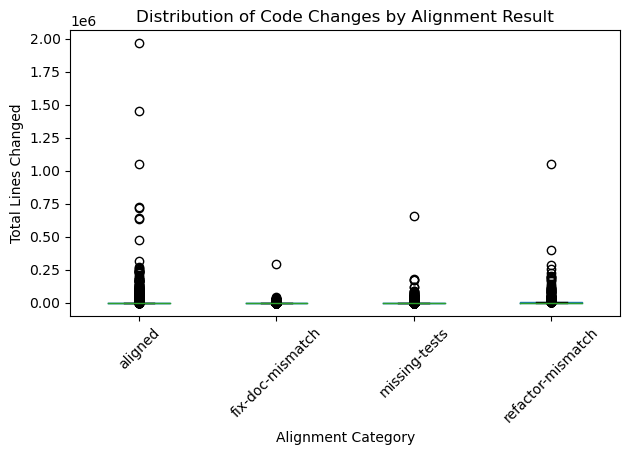

In [13]:
#For each mismatch category, how large are the code changes?
plt.figure(figsize=(12, 6))
merged.boxplot(
    column="changes",
    by="alignment_result",
    grid=False
)
plt.title("Distribution of Code Changes by Alignment Result")
plt.suptitle("")  # Remove default pandas title
plt.xlabel("Alignment Category")
plt.ylabel("Total Lines Changed")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


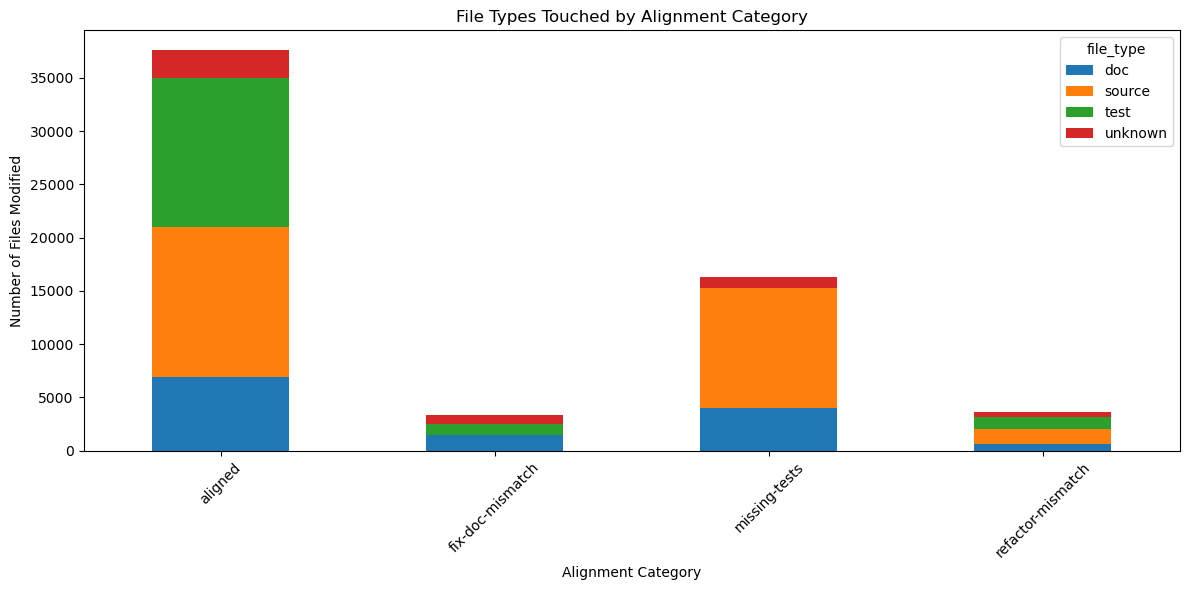

In [14]:
#File Types per Alignment Category
import pandas as pd

# Expand file_type list into separate rows
file_expanded = merged.explode("file_type")

# Count file_type frequency inside each alignment category
ft_counts = pd.crosstab(file_expanded["alignment_result"], file_expanded["file_type"])

ft_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6)
)

plt.title("File Types Touched by Alignment Category")
plt.xlabel("Alignment Category")
plt.ylabel("Number of Files Modified")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
